In [1]:
import geopandas as gpd
from tqdm import tqdm
from shapely.validation import explain_validity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import calendar
from itertools import cycle

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
os.chdir("../../scripts")
from clustering_operations import *

%load_ext autoreload
%autoreload 2

In [4]:
level = 8
shp_path = f"../data/shapefiles/FAPAN_level_0{level}/FAPAN_level_0{level}_corrected.shp"    
df_path = f"../data/FAPAN_level_0{level}_corrected.csv"

shp = gpd.read_file(shp_path)
df = pd.read_csv(df_path)

In [5]:
df.head()

,HYBAS_ID,SUBIDs,Common_Areas,1,2,3,4,5,6,7,...,195,196,197,198,199,200,201,202,203,204
0,2080000020,9000344,0.02380300421005852,-1.447500,-0.678500,-1.512667,-1.678333,-1.416167,-1.088333,-1.370667,...,1.250167,0.948167,0.757500,1.425500,1.163833,0.907167,0.702500,0.387333,1.142833,1.303167
1,2080000250,9750169,0.047660205477118515,-0.841611,-0.376611,-0.481278,-0.624333,0.071333,-0.095611,-0.331389,...,0.336889,-0.485333,-0.822944,0.466722,0.475667,0.332000,0.930167,0.325778,0.846389,1.177056
2,2080000350,9749915,0.010995166646483806,-0.592222,-0.208889,-0.185889,-0.250556,0.669333,0.972667,0.828222,...,0.735667,-0.988222,-1.369889,-0.304889,-0.462444,-0.347333,0.088667,-0.243333,0.012333,0.740778
3,2080808730,9750078_9749690,0.025352888781841616_0.022712036143727837,-0.373331,0.145135,0.317084,0.011597,0.653961,0.778227,0.617639,...,0.762785,-0.711955,-1.236576,-0.384805,0.119299,-0.016164,0.386007,0.300499,0.046449,0.806965
4,2080808800,9749915,0.015016916414809055,-0.592222,-0.208889,-0.185889,-0.250556,0.669333,0.972667,0.828222,...,0.735667,-0.988222,-1.369889,-0.304889,-0.462444,-0.347333,0.088667,-0.243333,0.012333,0.740778


In [6]:
#df = df.drop(["SUBIDs", "Common_Areas"], axis=1)
df = df.rename(columns={"HYBAS_ID" : "SUBID"})
shp = shp.rename(columns={"HYBAS_ID" : "SUBID"})

In [7]:
def select_columns_by_months(dataframe, selected_months):
    selected_columns = []

    for i in range((dataframe.shape[1] - 3) // 12):
        selected_columns.extend([month + i * 12 for month in selected_months])

    all_columns = np.arange(1, dataframe.shape[1]-2)
    columns_to_drop = np.setdiff1d(all_columns, np.array(selected_columns))
    columns_to_drop = [str(i) for i in columns_to_drop]

    filtered_dataframe = dataframe.drop(columns=columns_to_drop, axis=1)

    return filtered_dataframe

/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_54853/2989235827.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
100%|██████████| 12/12 [03:52<00:00, 19.40s/it]

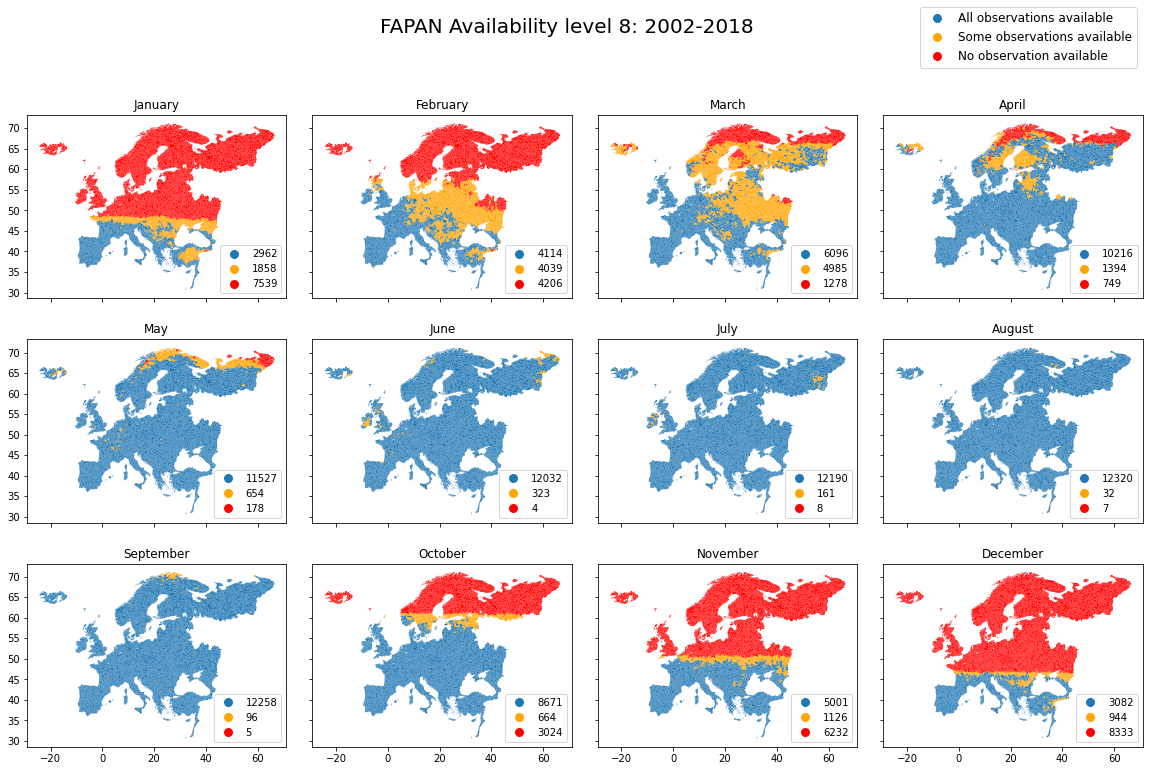

In [8]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True, constrained_layout=True)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

fig.suptitle(f'FAPAN Availability level {level}: 2002-2018', fontsize=20)
colors = {'df_month_no_na': 'C0', 'df_month_some_na': 'orange', 'df_month_all_na': 'red'}

progress_bar = tqdm(total=12, position=0, leave=True, smoothing=0)

k = 1
for i in range(3):
    for j in range(4):
        df_month = select_columns_by_months(df, [k])
        selected_columns = df_month.iloc[:, 3:]

        df_month_no_na = df_month.dropna()
        df_month_some_na = df_month[selected_columns.isnull().any(axis=1) & ~selected_columns.isnull().all(axis=1)]
        df_month_all_na = df_month[selected_columns.isnull().all(axis=1)]

        shp.plot(ax=axs[i][j], color=[colors.get('df_month_no_na') if subid in df_month_no_na['SUBID'].values
                                       else colors.get('df_month_some_na') if subid in df_month_some_na['SUBID'].values
                                       else colors.get('df_month_all_na') for subid in shp['SUBID']])

        month_name = calendar.month_name[k]
        axs[i][j].set_title(f'{month_name}', fontsize=12)

        # Count the occurrences of each color
        color_counts = [str(len(df_month_no_na)), str(len(df_month_some_na)), str(len(df_month_all_na))]

        axs[i][j].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
                                  for color in colors.values()],
                         labels=color_counts,
                         loc='lower right', fontsize=10)

        k += 1
        progress_bar.update(1)

# Create a legend outside the loop for the last plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
labels = ['All observations available', 'Some observations available', 'No observation available']
fig.legend(handles=handles, labels=labels, loc='upper right', fontsize=12, bbox_to_anchor=(0.9, 1))


#plt.savefig(fname='availability_each_month.png')

plt.show()

/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_54853/4080816599.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.05, hspace=0.1)
100%|██████████| 6/6 [01:27<00:00, 14.55s/it]

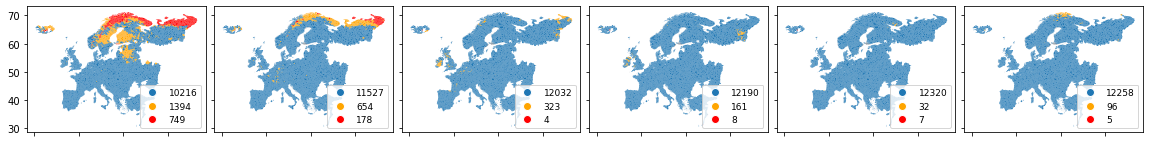

In [9]:
fig, axs = plt.subplots(1, 6, figsize=(20, 5), sharex=True, sharey=True, constrained_layout=True)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.1)

#fig.suptitle('FAPAN Availability level 7: 2002-2018', fontsize=20)
colors = {'df_month_no_na': 'C0', 'df_month_some_na': 'orange', 'df_month_all_na': 'red'}

progress_bar = tqdm(total=6, position=0, leave=True, smoothing=0)

k = 4
for i in range(1):
    for j in range(6):
        df_month = select_columns_by_months(df, [k])
        selected_columns = df_month.iloc[:, 3:]

        df_month_no_na = df_month.dropna()
        df_month_some_na = df_month[selected_columns.isnull().any(axis=1) & ~selected_columns.isnull().all(axis=1)]
        df_month_all_na = df_month[selected_columns.isnull().all(axis=1)]

        shp.plot(ax=axs[j], color=[colors.get('df_month_no_na') if subid in df_month_no_na['SUBID'].values
                                       else colors.get('df_month_some_na') if subid in df_month_some_na['SUBID'].values
                                       else colors.get('df_month_all_na') for subid in shp['SUBID']])

        month_name = calendar.month_name[k]
        #axs[j].set_title(f'{month_name}', fontsize=12)

        # Count the occurrences of each color
        color_counts = [str(len(df_month_no_na)), str(len(df_month_some_na)), str(len(df_month_all_na))]

        axs[j].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) 
                                  for color in colors.values()],
                         labels=color_counts,
                         loc='lower right', fontsize=9)
        
        axs[j].set_xticklabels([])  # Remove x-tick labels

        k += 1
        progress_bar.update(1)

# Create a legend outside the loop for the last plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
labels = ['All observations available', 'Some observations available', 'No observation available']
#fig.legend(handles=handles, labels=labels, loc='upper right', fontsize=12, bbox_to_anchor=(0.9, 1))


#plt.savefig(fname='availability_each_month.png')

plt.show()

In [10]:
def plot_availability(months, nan_threshold):
    df_month = select_columns_by_months(df, months)
    selected_columns = df_month.iloc[:, 3:]

    #df_month_no_na = df_month.dropna()
    df_month_a_or_less_na = df_month[selected_columns.isnull().sum(axis=1)<=nan_threshold]
    df_month_b_or_more_na = df_month[(selected_columns.isnull().sum(axis=1)>nan_threshold) & (~selected_columns.isnull().all(axis=1))]
    df_month_all_na = df_month[selected_columns.isnull().all(axis=1)]
    colors = {'df_month_a_or_less_na': 'C0', 'df_month_b_or_more_na': 'orange', 'df_month_all_na': 'red'}

    shp.plot(figsize=(16,16), color=[colors.get('df_month_a_or_less_na') if subid in df_month_a_or_less_na['SUBID'].values
                                    else colors.get('df_month_b_or_more_na') if subid in df_month_b_or_more_na['SUBID'].values
                                    else colors.get('df_month_all_na') for subid in shp['SUBID']])

    color_counts = [str(len(df_month_a_or_less_na)), str(len(df_month_b_or_more_na)), str(len(df_month_all_na))]

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
    labels = [f'{nan_threshold} or less observations missing ({color_counts[0]})', f'{nan_threshold+1} or more observations missing ({color_counts[1]})', f'No observation available ({color_counts[2]})']
    plt.legend(handles, labels, loc='lower right', fontsize='large')

    title = calendar.month_name[months[0]] if len(months) == 1 else ", ".join(calendar.month_name[m] for m in months)
    plt.title(title, fontsize = 16)

    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)

    plt.show()

In [ ]:
months = [4,5,6,7,8,9]
plot_availability(months, nan_threshold=0)

In [ ]:
shp.plot(figsize=(16,10), column=df['196'], cmap='RdYlGn', vmin=-2, vmax=2)
plt.title(f"Level {level}, April 2018", fontsize = 16)

### Consider lvl. X sub-basins that contain only sub-basins among the 35.000 that have at most 4 missing observations

In [11]:
df_coarser = pd.read_csv(f"../data/FAPAN_level_0{level}_corrected.csv")
df_finer = pd.read_csv("../data/FAPAN204_05.csv")

In [12]:
selected_months = [4,5,6,7,8,9]
df_coarser = select_columns_by_months(df_coarser, selected_months)
df_finer = select_columns_by_months(df_finer, selected_months)
df_finer = df_finer[(df_finer.isnull()).sum(axis=1)<=4]
df_finer = df_finer.reset_index(drop=True)
df_finer.shape

(30219, 105)

In [13]:
rows_to_drop = []
valid_subids = list(df_finer["SUBID"])

for i in range(df_coarser.shape[0]):
    subids = list(map(int, df_coarser.loc[i, "SUBIDs"].split("_")))
    if not all(subid in valid_subids for subid in subids):
        rows_to_drop.append(i)        

df_coarser = df_coarser.drop(rows_to_drop)
df_coarser = df_coarser.reset_index(drop=True)
df_coarser.shape        

(10831, 105)

Text(0.5, 1.0, 'Lvl. 8 sub-basins which contain only original sub-basins \nwith at most 4 missing observations')

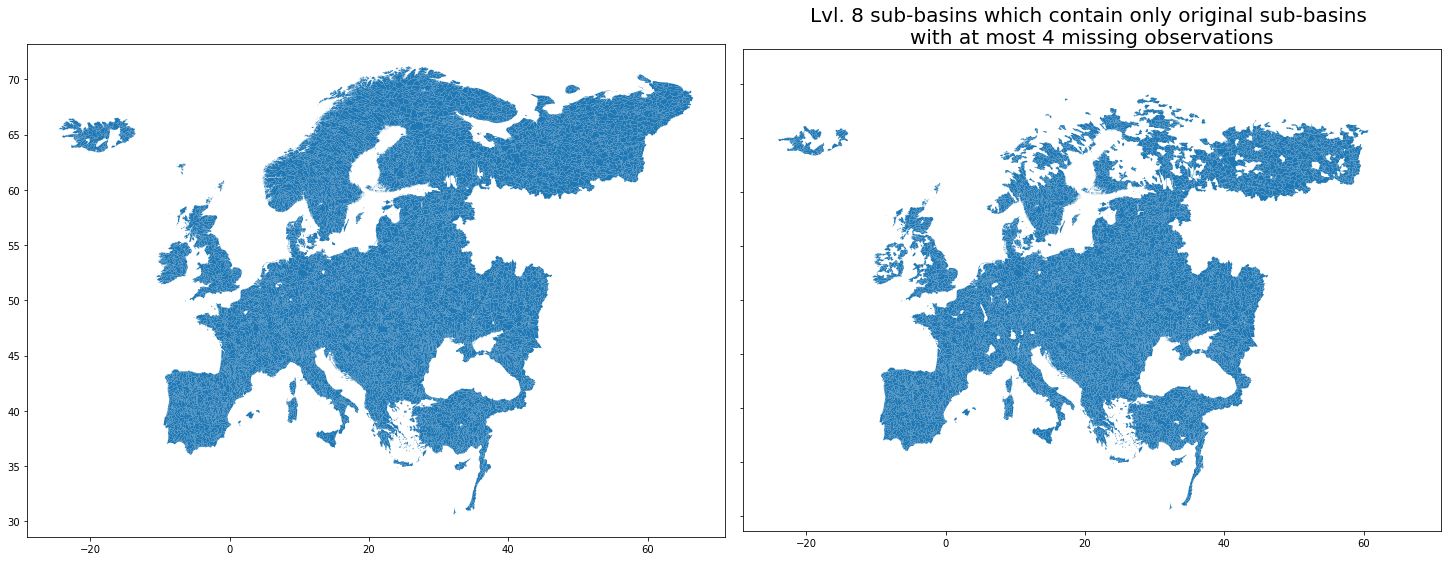

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 12), sharex=True, sharey=True, constrained_layout=True)
shp.plot(ax=axes[0])
axes[0].set_title('', fontsize=20)

shp_coarser = shp[shp["SUBID"].isin(df_coarser["HYBAS_ID"])]
shp_coarser.plot(ax=axes[1])
axes[1].set_title(f'Lvl. {level} sub-basins which contain only original sub-basins \nwith at most 4 missing observations', fontsize=20)

In [15]:
shp_coarser.to_file(f'../data/shapefiles/FAPAN_level_0{level}/comparison_4na.shp')

(array([8.941e+03, 1.243e+03, 4.610e+02, 1.500e+02, 1.600e+01, 9.000e+00,
        5.000e+00, 2.000e+00, 1.000e+00, 3.000e+00]),
 array([ 1. ,  4.3,  7.6, 10.9, 14.2, 17.5, 20.8, 24.1, 27.4, 30.7, 34. ]),
 <BarContainer object of 10 artists>)

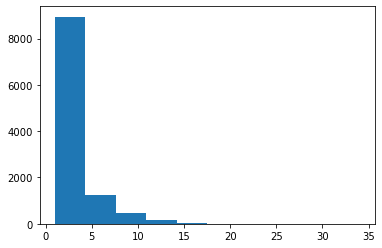

In [16]:
clusters = []
clusters_mean = []

for i in range(df_coarser.shape[0]):
    clusters.append(list(map(int, df_coarser.iloc[i, 1].split("_"))))
    clusters_mean.append(list(df_coarser.iloc[i, 3:].values.flatten()))

combined_lists = list(zip(clusters, clusters_mean))
sorted_combined_lists = sorted(combined_lists, key=lambda x: len(x[0]), reverse=True)
clusters, clusters_mean = zip(*sorted_combined_lists)
clusters = list(clusters)    
count = [len(cluster) for cluster in clusters]
plt.hist(count)

In [17]:
# Transpose the DataFrame and set the "SUBID" column as the column names
df_finer = df_finer.drop(['x', 'y'], axis=1)
df_finer = df_finer.set_index('SUBID').T
df_finer = df_finer.reset_index(drop=True)
df_finer = df_finer.rename_axis(None, axis=1)
df_finer = df_finer.astype(float)
df_finer.head()

,8000005,8115258,8115717,8102609,8103951,8000007,8000006,8210493,8210176,8000018,...,9566462,9566535,9566624,9566991,9566510,9566395,9581818,9524166,9581815,9723401
0,0.187556,-0.245083,0.242000,0.371667,0.090185,0.109810,0.305719,-0.454667,-0.634556,-0.557667,...,0.831286,0.821733,0.943467,0.689667,0.638083,0.870333,0.682400,-0.657000,0.463182,-0.200100
1,0.371778,0.815444,-0.082444,0.523533,0.343000,0.041429,0.364721,0.485061,0.307556,0.219333,...,-0.766611,-0.540400,-0.744600,-1.734000,-1.239000,-0.808333,-0.305400,0.157000,-0.502667,0.310800
2,-0.197000,-0.115556,-1.187556,-0.586733,-0.465481,-0.923905,-0.561440,0.606697,0.368333,0.504778,...,-1.160905,-0.826400,-0.524267,-1.406667,-1.086250,-0.600833,-1.754267,-0.911500,-1.733000,-0.289100
3,-0.361333,-0.607519,-0.751778,-0.437733,-0.418556,-0.676571,-0.682685,-0.545758,-0.859056,0.273444,...,-0.487524,-0.761867,0.194400,-0.672000,-0.640250,-0.217667,-1.219133,-0.898167,-0.600292,-0.275567
4,1.086444,1.011852,0.860667,0.851200,0.877259,0.887905,1.097896,-0.471576,-0.513278,0.653556,...,0.425190,0.752800,0.876667,0.255667,0.328833,-0.116167,0.590200,-0.902500,0.641636,-0.389833


100%|██████████| 10831/10831 [01:16<00:00, 141.29it/s]


No. clusters (w/o singletons): 7106
No. singletons): 3725


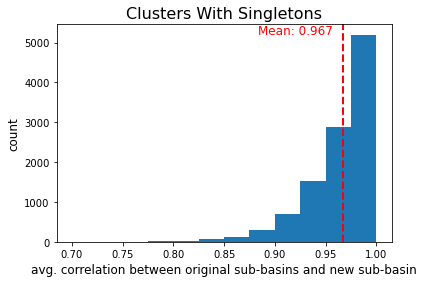

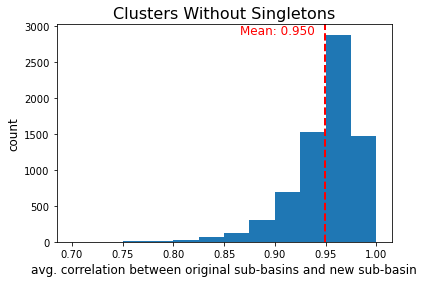

In [19]:
avg_corr_with_mean = correlations_sub_cluster(df_finer, clusters, clusters_mean)
no_singletons = remove_singletons(clusters)
print(f'No. clusters (w/o singletons): {len(no_singletons)}')
print(f'No. singletons): {len(avg_corr_with_mean) - len(no_singletons)}')
plot_hist_with_mean(avg_corr_with_mean, title="Clusters With Singletons")
plot_hist_with_mean(avg_corr_with_mean[:len(no_singletons)], title="Clusters Without Singletons")